#Let's import the libraries 

In [0]:

import time
import os
import copy


import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms

from __future__ import print_function, division



# Lets load the Google Drive into current Google Colab instance 

In [3]:

from google.colab import drive
drive.mount('/content/gdrive')   

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **We need to change the directory where we have the data folder inside which we have train and validation folder.**

In [4]:
%cd /content/gdrive/My\ Drive/


/content/gdrive/My Drive


In [6]:
cd ./Colab \Notebooks

/content/gdrive/My Drive/Colab Notebooks


In [0]:
#!ls

# **Performing Data augmentation and normalization for training data set**



In [0]:
transform_imgs = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Defining data directory and dataloaders for getting batches of images during training 

In [0]:

data_dir = 'DATA_FILES'

img_data = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          transform_imgs[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(img_data[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}


data_size = {x: len(img_data[x]) for x in ['train', 'val']}

class_names = img_data['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#**Lets check the dataloaders and see X and Y dimentions**

In [0]:
X,Y=next(iter(dataloaders['train']))

In [10]:
X.shape

torch.Size([4, 3, 224, 224])

In [11]:
Y.shape

torch.Size([4])

In [12]:
Y.data.numpy()

array([0, 0, 0, 1])

# **Visualizing few training images with their class labels**

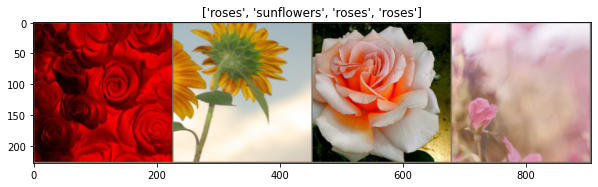

array([0, 1, 0, 0])

In [15]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(10,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, output = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

#Now plot
imshow(out, title=[class_names[x] for x in output])

#Now lets see the labels 
output.data.numpy()

In [0]:
def train_model(model, loss_fn, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict()) #Lets create a copy of the pretrained model weights and keep updating as training goes on 
    best_acc = 0.0

    for epoch in range(num_epochs):               #This loop is for number of epochs
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, output in dataloaders[phase]:
                inputs = inputs.to(device)
                output = output.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    probabilities = model(inputs)   #Get the probabilities for set of images
                    _, predictions = torch.max(probabilities, 1)  #Get the prediction for each batch image based on maximum probability
                    loss = loss_fn(probabilities, output)        #Calculate the loss function from the output label and predicted probabilities

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()        #Then Backward propagation
                        optimizer.step()        #Then update paramaters of model

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(predictions == output.data)

            epoch_loss = running_loss / data_size[phase]
            epoch_acc = running_corrects.double() / data_size[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Update the model weights if model validation accuracy is better than before 
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # return the model with  best model weights
    model.load_state_dict(best_model_wts)
    return model

# **Loading the RESNET Pretrained model and changing its last fully connected layer and finetuning it**



In [0]:
#Let's take the pretrained RESNET model and change the last the last layer and fine tune it 
model_fun = models.resnet50(pretrained=True)

#If We  set requires_grad == False then we train only last layer otherwise we train whole model from scratch with initial weights as RESENET model
#But training only last layer is faster than training whole set of layers 
for param in model_fun.parameters():
  param.requires_grad = False

##Changing the last layer with 2 neurons as output because we have two classes
num_ftrs = model_fun.fc.in_features
model_fun.fc = nn.Linear(num_ftrs, 2)

#Sending Model to CUDA for training
model_fun = model_fun.to(device)

##Loss Function
loss_fn = nn.CrossEntropyLoss()

#Optimizer
optimizer = optim.SGD(model_fun.parameters(), lr=0.001, momentum=0.5)

# Decay Learning rate of optimizer by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# **Model Training Begins Now**

In [23]:
model = train_model(model_fun, loss_fn, optimizer, exp_lr_scheduler,
                       num_epochs=20)

Epoch 0/19
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.6542 Acc: 0.7727
val Loss: 0.3082 Acc: 0.9063

Epoch 1/19
----------
train Loss: 0.4314 Acc: 0.8669
val Loss: 0.5320 Acc: 0.8574

Epoch 2/19
----------
train Loss: 0.6215 Acc: 0.8269
val Loss: 0.3199 Acc: 0.8982

Epoch 3/19
----------
train Loss: 0.6801 Acc: 0.8327
val Loss: 0.2251 Acc: 0.9308

Epoch 4/19
----------
train Loss: 0.4671 Acc: 0.8481
val Loss: 0.2204 Acc: 0.9246

Epoch 5/19
----------
train Loss: 0.7358 Acc: 0.8198
val Loss: 0.1587 Acc: 0.9491

Epoch 6/19
----------
train Loss: 0.3161 Acc: 0.9046
val Loss: 0.1133 Acc: 0.9695

Epoch 7/19
----------
train Loss: 0.3559 Acc: 0.8916
val Loss: 0.0959 Acc: 0.9817

Epoch 8/19
----------
train Loss: 0.3029 Acc: 0.9046
val Loss: 0.0930 Acc: 0.9695

Epoch 9/19
----------
train Loss: 0.3632 Acc: 0.8799
val Loss: 0.1067 Acc: 0.9756

Epoch 10/19
----------
train Loss: 0.2814 Acc: 0.8916
val Loss: 0.1368 Acc: 0.9593

Epoch 11/19
----------
train Loss: 0.3238 Acc: 0.8999
val Loss: 0.0879 Acc: 0.9776

Epoch 12/19
----------
t

# **Lets define a function for predictions for test images and image visualization**

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, output) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)  ##Getting the inputs from the batch of test images.
            output = output.to(device)  ##Getting the output labels for the same set of 6 test images.

            probabilities = model(inputs)  ##Getting the predictions with probabilties for each class 
            _, predictions = torch.max(probabilities, 1)   ##Getting actual prediction based on higher probability 

            for j in range(inputs.size()[0]):    ##Loop running for number of batch size.So for each image we will one subplot
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[predictions[j]])) ##Getting the class name for one of the 6 test images
                imshow(inputs.cpu().data[j])  ##Converting inputs pytorch variable into numpy using data method .

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

# **Lets visualize the model predictions for the test images**




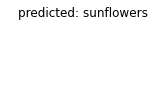

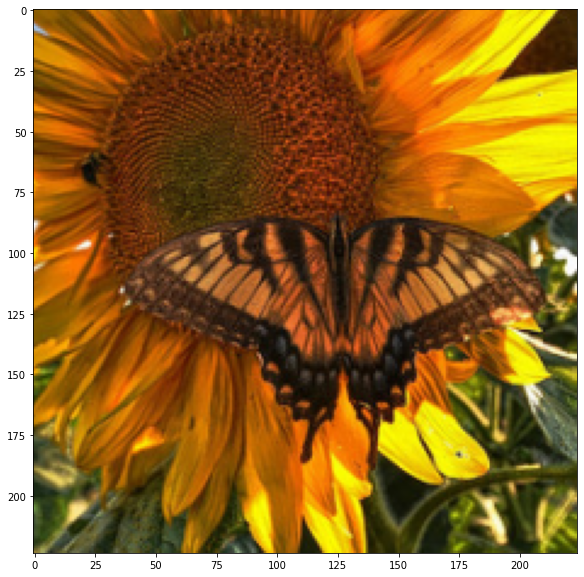

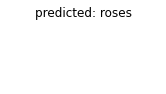

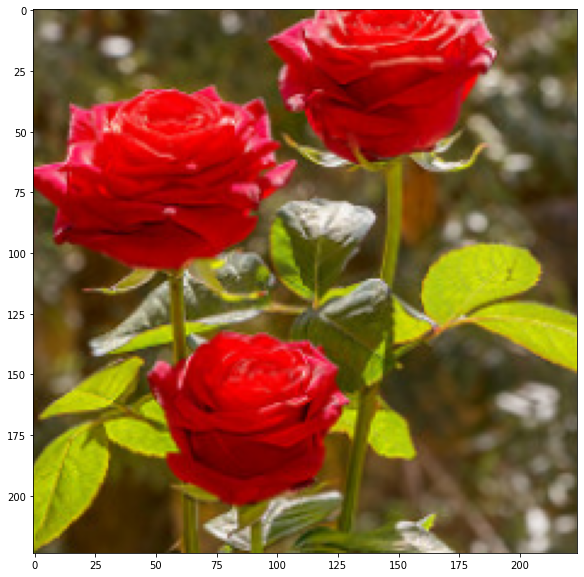

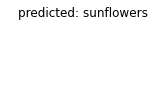

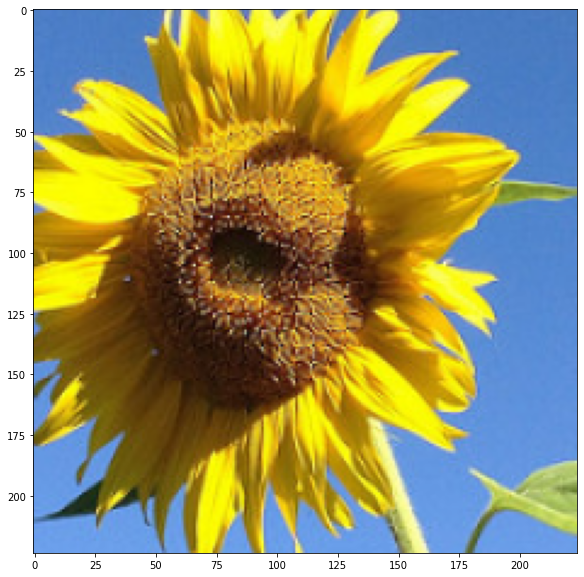

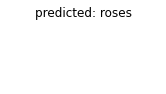

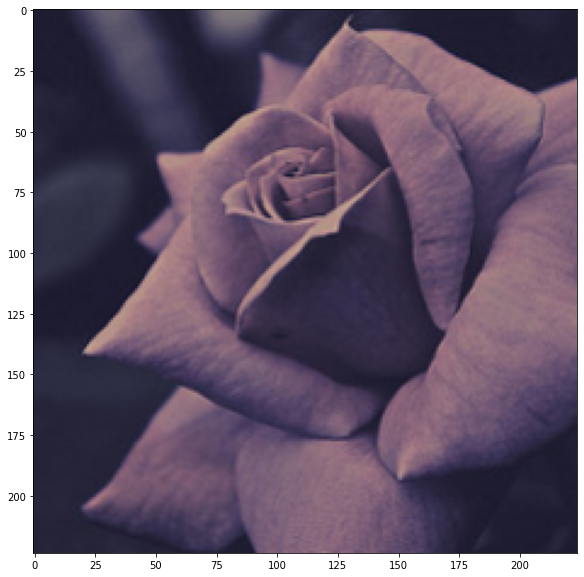

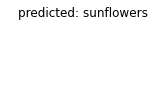

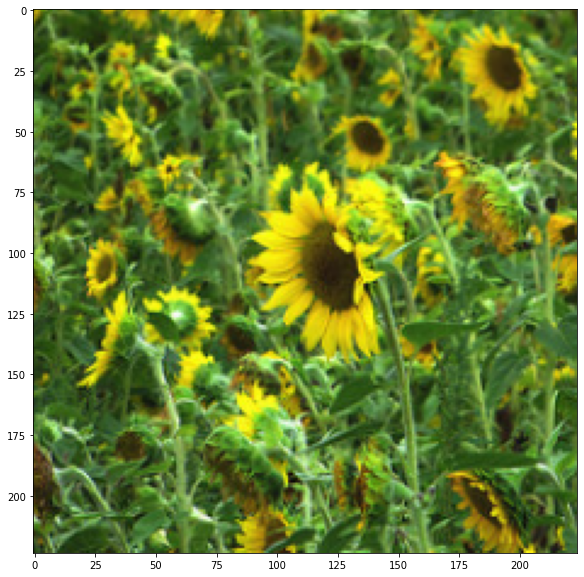

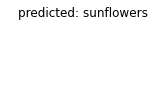

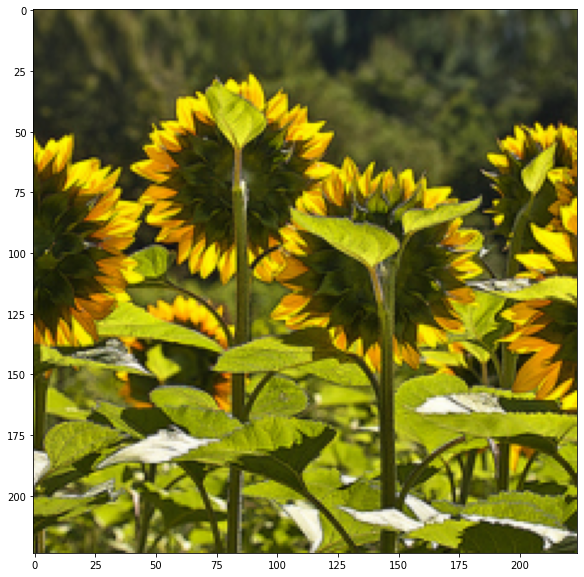

In [31]:

visualize_model(model)

In [26]:
!ls ./DATA_FILES/train

roses  sunflowers
